In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

# **Capstone Project 1**

### **Problem Statement**   

Buying a house can be a very challenging process. It takes time, patience, and a lot of research to find a house that you like and then negotiate the right price for it. There are several features that influence house price such as the building type, total number of rooms, garage size, masonary work, location, utilities, and many more. Can house price be estimated (or predicted) using these features? Can we identify features that influence house price the most? How important is Building Type in determining the price? What influences the price more: location or size (sq.ft.)? How much value does remodeling add to the house? These are a few questions among many more that I intend to explore and answer.

### **Dataset**

Dataset is available on kaggle (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). It is the Ames Housing dataset, compiled by Dean De Cock. It has 1460 instances and 79 explanatory variables that describe almost every aspect of residential homes in Ames, Iowa.

## **1. Data Wrangling**

In this part, we will explore the data. In the process, we will clean and augment the data with additional information from other sources. We will perform the following steps:

- Identify and remove outliers
- Fill missing values
- Augment the dataset by collecting and adding data from other sources like Google's Geocoding API and uszipcode library

### Import useful libraries

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import matplotlib as mpl
import seaborn as sns

sns.set(style ='white',font_scale=1.25)

%matplotlib inline

### Load the dataset, and look at first few rows

In [3]:
housing_raw = pd.read_csv('../data/01-House-Price/train.csv',index_col='Id')
housing = housing_raw.copy()
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Datatype of each column

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

We can see there are a lot of numerical and categorical features.  
Lets first take look at the numerical (particularly continous) features to spot outliers.

### **1.1. Outliers**

In [5]:
# Created a list of continous features to check their distribution and spot potential outliers
cont_feats = ['SalePrice','LotFrontage',
              'LotArea','MasVnrArea',
              'BsmtFinSF1','BsmtFinSF2',
              'BsmtUnfSF','TotalBsmtSF',
              '1stFlrSF','2ndFlrSF',
              'LowQualFinSF','GrLivArea',
              'GarageArea','WoodDeckSF',
              'OpenPorchSF','EnclosedPorch',
              'ScreenPorch']

### Distributions of the continous features.

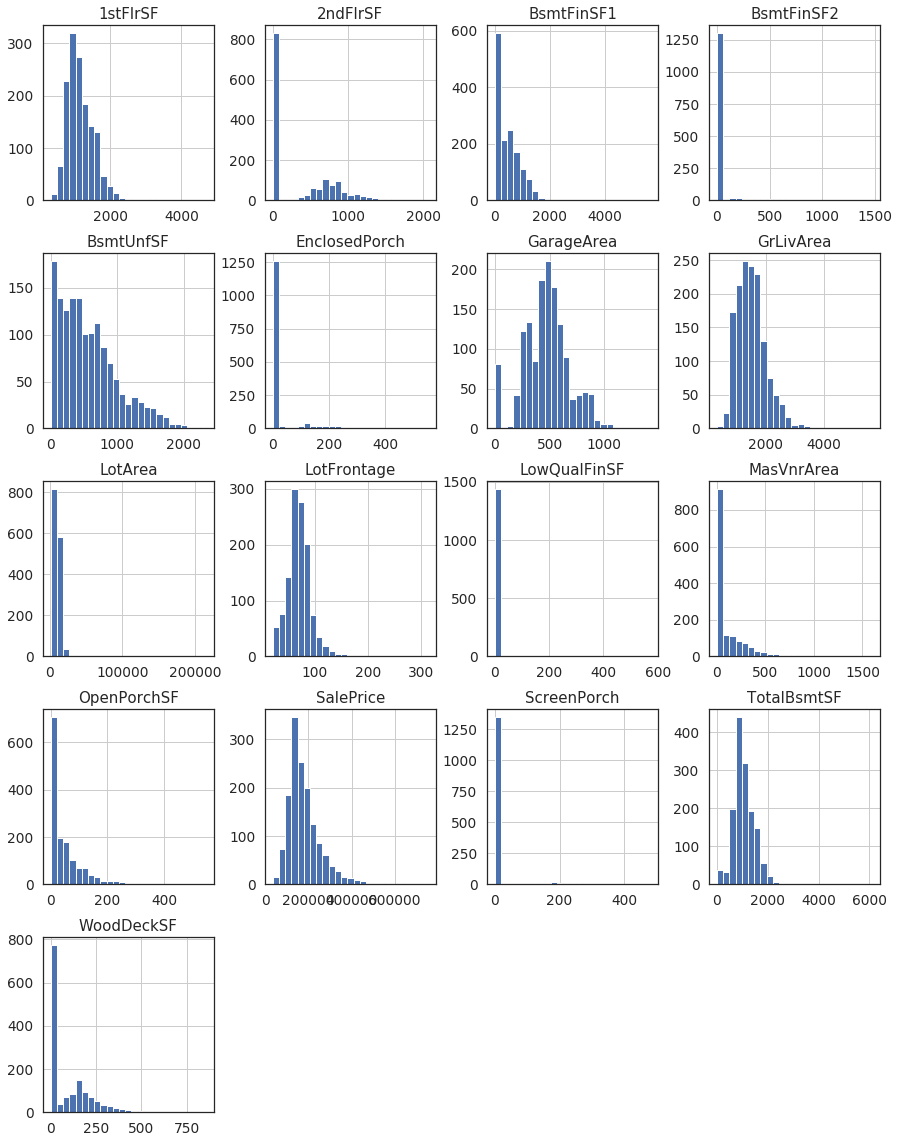

In [6]:
_=housing[cont_feats].hist(figsize = (15,20),bins=25)

### SalePrice (target variable)

In [7]:
from scipy import stats

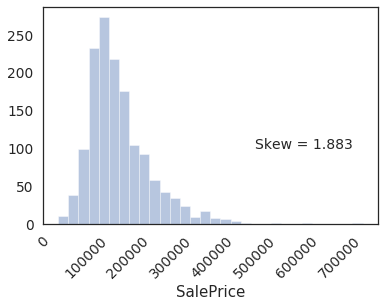

In [8]:
sns.distplot(housing.SalePrice, kde=False, bins=30)
plt.text(x=5e5, y=100,s='Skew = %.3f' %(housing.SalePrice.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

Distribution has a postive skew.  Let apply a log tranform.

In [9]:
housing['log1p(SalePrice)'] = np.log1p(housing['SalePrice'])

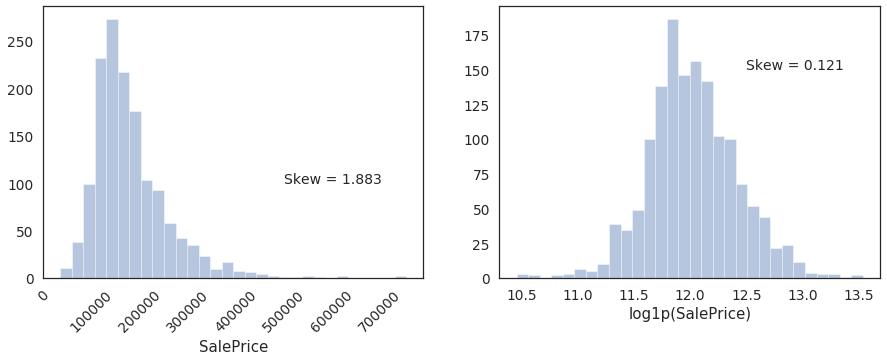

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(housing.SalePrice, kde=False, bins=30)
plt.text(x=5e5, y=100,s='Skew = %.3f' %(housing.SalePrice.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

plt.subplot(1,2,2)
sns.distplot(housing['log1p(SalePrice)'], kde=False, bins=30)
_=plt.text(x=12.5, y=150,s='Skew = %.3f' %(housing['log1p(SalePrice)'].skew()),fontdict={'fontsize':14})

Looks close to normal after tranforming.

### GrLivArea

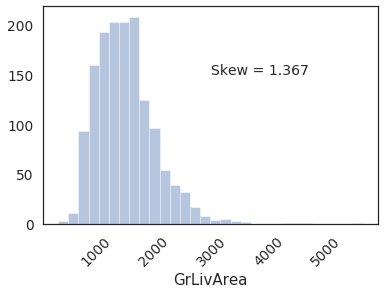

In [11]:
sns.distplot(housing.GrLivArea, kde=False, bins=30)
plt.text(x=3000, y=150,s='Skew = %.3f' %(housing.GrLivArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

Distribution has positve skew.

Text(0, 0.5, 'SalePrice')

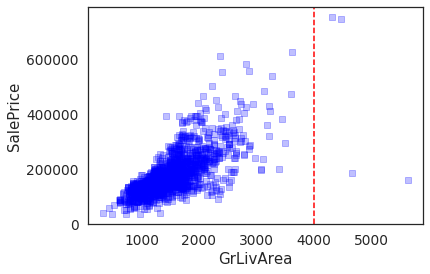

In [12]:
plt.scatter(housing.GrLivArea, housing.SalePrice, c='blue',marker = 's',alpha=0.25)
plt.axvline(x=4000,color='red',linestyle='--')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

Lets remove examples that have GrLivArea > 4000

In [13]:
outlier = pd.DataFrame()
out_var = []
outlier['GrLivArea'] = housing.GrLivArea > 4000
out_var.append('GrLivArea')

Text(0.5, 1.0, 'After removing GrLivArea > 4000')

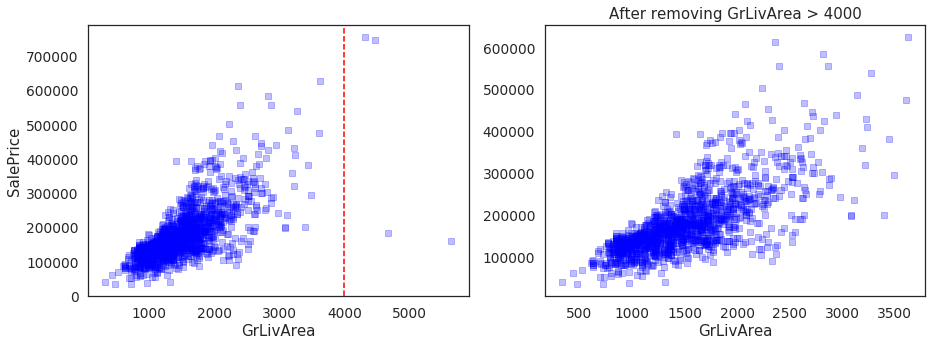

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(housing.GrLivArea, housing.SalePrice, c='blue',marker = 's',alpha=0.25)
plt.axvline(x=4000,color='red',linestyle='--')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

plt.subplot(1,2,2)
plt.scatter(housing[~outlier.any(axis=1)].GrLivArea, housing[~outlier.any(axis=1)].SalePrice, c='blue',marker = 's',alpha=0.25)
plt.xlabel('GrLivArea')
plt.ylabel('')
plt.title('After removing GrLivArea > 4000')

No apparent outliers in the right scatter plot

Lets also apply log tranform to GrLivArea.

In [15]:
housing['log1p(GrLivArea)'] = np.log1p(housing.GrLivArea)

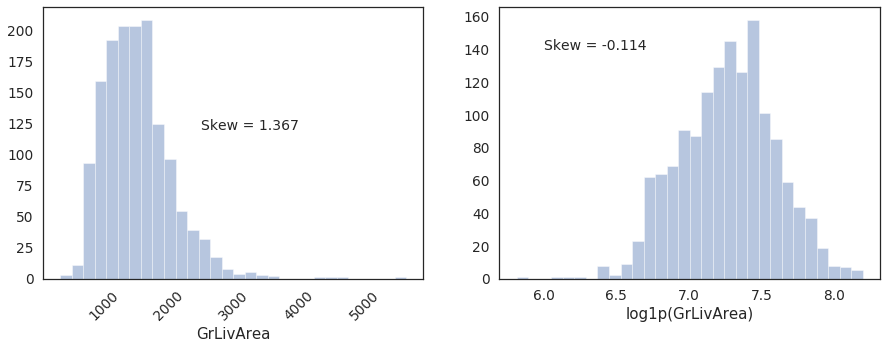

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(housing.GrLivArea, kde=False, bins=30)
plt.text(x=2500, y=120,s='Skew = %.3f' %(housing.GrLivArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

plt.subplot(1,2,2)
sns.distplot(np.log1p(housing[~outlier.any(axis=1)].GrLivArea), kde=False, bins=30)
_=plt.text(x=6, y=140,s='Skew = %.3f' %(np.log1p(housing[~outlier.any(axis=1)].GrLivArea).skew()),fontdict={'fontsize':14})
_=plt.xlabel('log1p(GrLivArea)')

Looks close to normal after log transform.

### GarageArea

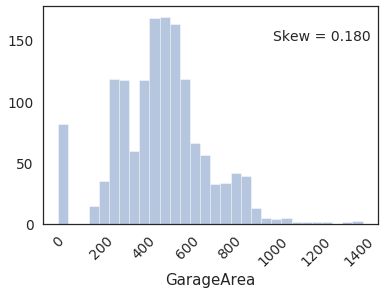

In [17]:
sns.distplot(housing.GarageArea, kde=False, bins=30)
plt.text(x=1000, y=150,s='Skew = %.3f' %(housing.GarageArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

Distibution looks reasonably normal.

Text(0, 0.5, 'SalePrice')

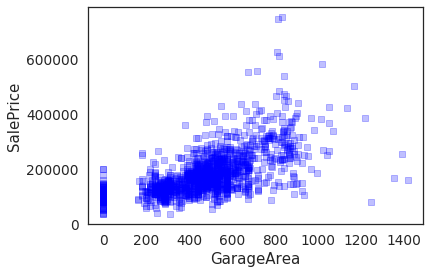

In [18]:
plt.scatter(housing.GarageArea, 
            housing.SalePrice, c='blue',marker = 's',alpha=0.25)
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')

No apparent outliers in the scatter plot

### LotArea

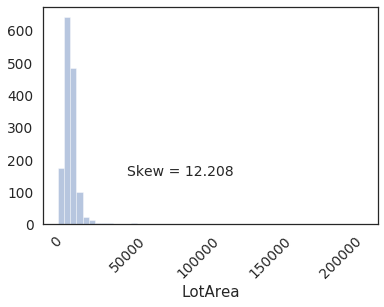

In [19]:
sns.distplot(housing.LotArea, kde=False, bins=50)
plt.text(x=50000, y=150,s='Skew = %.3f' %(housing.LotArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

Distribution is highly skewed due to outliers.

Text(0, 0.5, 'SalePrice')

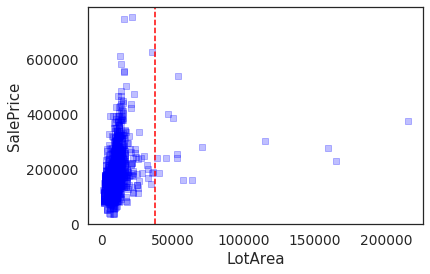

In [20]:
plt.scatter(housing.LotArea, 
            housing.SalePrice, c='blue',marker = 's',alpha=0.25)
percentile = np.percentile(housing.LotArea,99) # value at 99th percentile
plt.axvline(x=percentile,color='red',linestyle='--')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')

Text(0.5, 1.0, 'After removing Lot Area > 37568 sq.ft.')

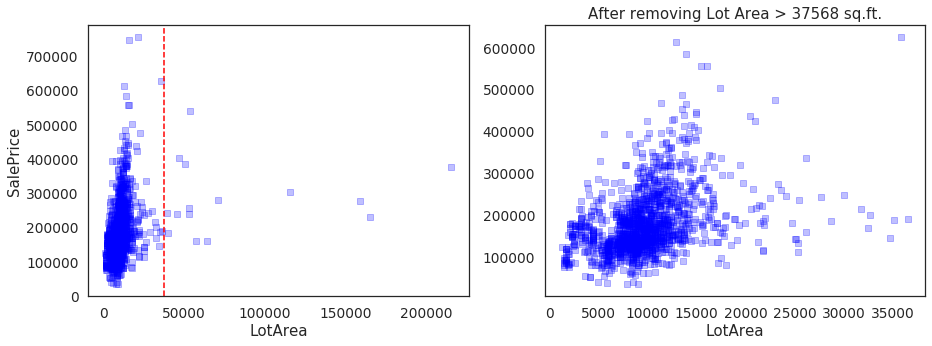

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(housing.LotArea, 
            housing.SalePrice, 
            c='blue',marker = 's',alpha=0.25)
plt.axvline(x=percentile,color='red',linestyle='--')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')

outlier['LotArea'] = housing.LotArea > percentile # 3e4

plt.subplot(1,2,2)
plt.scatter(housing[~outlier.any(axis=1)].LotArea, housing[~outlier.any(axis=1)].SalePrice, c='blue',marker = 's',alpha=0.25)
plt.xlabel('LotArea')
plt.ylabel('')
plt.title('After removing Lot Area > %.0f sq.ft.' %(percentile))

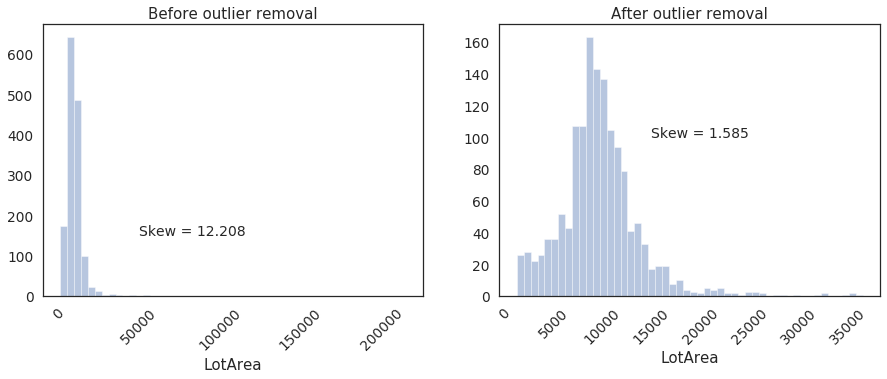

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(housing.LotArea, kde=False, bins=50)
plt.text(x=50000, y=150,s='Skew = %.3f' %(housing.LotArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)
_=plt.title('Before outlier removal')

plt.subplot(1,2,2)
sns.distplot(housing[~outlier.any(axis=1)]['LotArea'], kde=False, bins=50)
plt.text(x=15000, y=100,s='Skew = %.3f' %(housing[~outlier.any(axis=1)]['LotArea'].skew()),fontdict={'fontsize':14})
_=plt.title('After outlier removal')
_=plt.xticks(rotation = 45)

Skeweness improved considerably after removing outliers

Distribution has looks reasonably normal.

In [23]:
print('Number of examples before outlier removal: ',housing.shape[0])
print('Number of examples after outlier removal: ',housing[~outlier.any(axis=1)].shape[0])
print('%i examples are excluded' %(housing.shape[0]-housing[~outlier.any(axis=1)].shape[0]))

Number of examples before outlier removal:  1460
Number of examples after outlier removal:  1443
17 examples are excluded


In [24]:
housing = housing[~outlier.any(axis=1)]

For more advanced methods of dealing with outliers, ref to:  
    1. https://pyod.readthedocs.io/en/latest/  
    2. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest

In the next step we will treat missing values.

### **1.2. Missing Values**

### **1.2.1. Categorical features**
Lets first treat missing values in the categorical features  

In [25]:
from collections import defaultdict
FEATURES = defaultdict(list)

**MSSubclass** is a categorical feature but it got loaded as a numerical feature, so lets change it to categorical.

In [26]:
housing['MSSubClass'] = housing['MSSubClass'].astype(str)

In [27]:
missing_vals_cat = pd.DataFrame(columns=['Feature', '# of missing vals','% of missing vals'])
for feature, numNan in housing.isnull().sum().iteritems():
    if housing[feature].dtypes == 'object':
        FEATURES['cat'].append(feature)
        if numNan != 0:
            missing_vals_cat = pd.concat([missing_vals_cat,pd.DataFrame([feature,numNan,(numNan/housing.shape[0])*100],
                                                                        index=['Feature', '# of missing vals','% of missing vals']).T])
            
missing_vals_cat.sort_values(by=['% of missing vals'],ascending=False).reset_index(drop=True)

,Feature,# of missing vals,% of missing vals
0,PoolQC,1438,99.6535
1,MiscFeature,1391,96.3964
2,Alley,1352,93.6937
3,Fence,1163,80.596
4,FireplaceQu,690,47.817
5,GarageType,81,5.61331
6,GarageFinish,81,5.61331
7,GarageQual,81,5.61331
8,GarageCond,81,5.61331
9,BsmtExposure,38,2.6334


There are two categorical features, **Electrical** and **MasVnrType**, that have missing values. Both have insignificant amounts of missing values (0.072% and 0.51%), hence it will be reasonable to impute them with the most frequently occuring category.

All other features have "meaningful" missing values. For example, if a house does not have a basement, all features related basement are going to be null values. Hence, replace those missing values in another category called "**Missing**".

### Electrical & MasVnrType

Text(0.5, 1.0, 'MasVnrType')

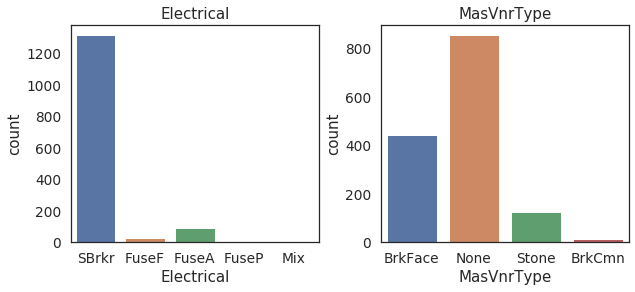

In [28]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(10,4))
fig.subplots_adjust(wspace=0.25)
sns.countplot(x='Electrical',data=housing,ax=ax1)
ax1.set_title('Electrical')
sns.countplot(x='MasVnrType',data=housing,ax=ax2)
ax2.set_title('MasVnrType')

***SBrkr*** is the most frequent category in the **Electrical**.

***None*** is the most frequent category in **MasVnrType**.

Impute the missing categories with most frequently occuring ones.

In [29]:
def Impute(housing,attrib=['Electrical','MasVnrType']):
    #housing = housing[FEATURES['cat']].copy()
    for a in attrib:
        mode = housing[a].mode()[0]
        housing[a] = housing[a].fillna(mode)
    
    for col in FEATURES['cat']:
        housing[col].fillna('Missing',inplace=True)

    return housing

### Check if there are still missing values in the categorical features.

In [30]:
housing = Impute(housing)
housing[FEATURES['cat']].isnull().sum()

MSSubClass       0
MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
dtype: int64

### **1.2.2. Numerical Features**

In [31]:
missing_vals_num = pd.DataFrame(columns=['Feature','# of missing values','% of missing values'])
for feature, numNan in housing.isnull().sum().iteritems():
    if housing[feature].dtypes!= 'object' and 'SalePrice' not in feature:
        FEATURES['num'].append(feature)
        if numNan != 0:
            missing_vals_num = pd.concat([missing_vals_num,
                                          pd.DataFrame([feature,numNan,
                                                        (numNan/housing.shape[0])*100],
                                                       index=['Feature','# of missing values','% of missing values']).T])

missing_vals_num.reset_index(drop = True).sort_values(by='# of missing values',ascending=False)

,Feature,# of missing values,% of missing values
0,LotFrontage,253,17.5329
2,GarageYrBlt,81,5.61331
1,MasVnrArea,8,0.554401


**MasVnrArea**: Since the most common category (None) was imputed for the missing values in the cat feature, **MasVnrType**, it will make sense to impute missing values in **MasVnrArea** with median **MasVnrArea** value of houses that have "None" as the **MasVnrType**.

In [32]:
MedianMasVnrArea = housing[housing['MasVnrType'] == 'None']['MasVnrArea'].median()
housing['MasVnrArea'].fillna(MedianMasVnrArea,inplace=True)

**GarageYrBlt**: these are same rows which have missing values in other garage related features, indicating that these houses do not have a garage. Imputing median value is a safe option, as these houses have already been flagged as missing a garage in the categorical features.

In [33]:
housing['GarageYrBlt'].fillna(housing['GarageYrBlt'].median(),inplace=True)
print("Median GarageYrBlt: ",housing['GarageYrBlt'].median())

Median GarageYrBlt:  1980.0


**LotForntage**: missing values needs to be handled more carefully as they amount to 17.73% of the total oberservation.

   - Let's take a look at the other three features associated with Lot: LotConfig, LotShape, and LotArea

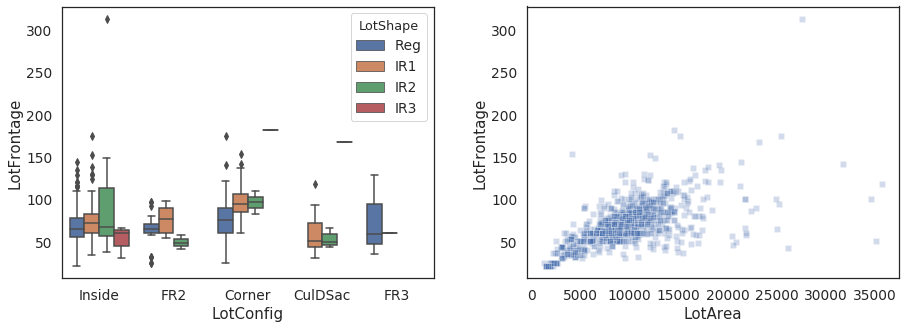

In [34]:
plt.figure(figsize = (15,5))
plt.subplots_adjust(wspace=0.25)
plt.subplot(1,2,1)
sns.boxplot(x='LotConfig',y='LotFrontage',data=housing,hue='LotShape')
plt.subplot(1,2,2)
sns.scatterplot(x='LotArea',y='LotFrontage',data=housing,marker='s',alpha=0.25)

### Impute missing LotFrontage in the following way:  
   - Group the data by **LotShape** and **LotConfig** and compute group specific median **LotFrontage**. 
   - Impute missing **LotFrontage** with group specific median LotFrontage values.

In [35]:
housing.groupby(['LotConfig','LotShape'])['LotFrontage'].median().to_dict()

{('Corner', 'IR1'): 94.5,
 ('Corner', 'IR2'): 96.0,
 ('Corner', 'IR3'): 182.0,
 ('Corner', 'Reg'): 75.0,
 ('CulDSac', 'IR1'): 50.0,
 ('CulDSac', 'IR2'): 49.0,
 ('CulDSac', 'IR3'): 168.0,
 ('CulDSac', 'Reg'): nan,
 ('FR2', 'IR1'): 77.0,
 ('FR2', 'IR2'): 48.0,
 ('FR2', 'Reg'): 64.5,
 ('FR3', 'IR1'): 60.0,
 ('FR3', 'Reg'): 59.0,
 ('Inside', 'IR1'): 71.5,
 ('Inside', 'IR2'): 67.0,
 ('Inside', 'IR3'): 60.0,
 ('Inside', 'Reg'): 65.0}

In [36]:
def imputeLotFrontage(housing):
    LotFrontageImuter = housing.groupby(['LotConfig','LotShape'])['LotFrontage'].median().to_dict()
    for key,val in LotFrontageImuter.items():
        LotConfig,LotShape = key
        housing.loc[(housing['LotFrontage'].isnull()) & (housing['LotConfig']==LotConfig) & (housing['LotShape']==LotShape),['LotFrontage']] = val
        
    housing.loc[housing['LotFrontage'].isnull(),'LotFrontage'] = housing['LotFrontage'].median()
    return housing

In [37]:
housing = imputeLotFrontage(housing)

In [38]:
housing.isnull().sum().sum()

0

**Data cleaning is done at this point.**

Next, we will add more data to the dataset from other sources.

### **1.3. Data Augmentation**
In this part, we will add more features to the dataset by gathering data from other sources like **Google's Geocoding API** and **uszipcode** library. 

### Count number of unique categories per categorical feature

In [39]:
unique_cats = defaultdict(int)

for col in housing.columns:
    if housing[col].dtypes == 'object':
        unique_cats[col] = housing[col].nunique()
        #print('{0}:\t\t {1} unique categories'.format(col,housing_cat[col].nunique()))

num_unique_cats = pd.Series(unique_cats)
num_unique_cats.sort_values(ascending = False)

Neighborhood     25
Exterior2nd      16
MSSubClass       15
Exterior1st      15
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
GarageType        7
Functional        7
BsmtFinType1      7
BsmtFinType2      7
Heating           6
RoofStyle         6
RoofMatl          6
SaleCondition     6
Foundation        6
FireplaceQu       6
GarageCond        6
GarageQual        6
MSZoning          5
LotConfig         5
MiscFeature       5
Fence             5
BldgType          5
HeatingQC         5
ExterCond         5
Electrical        5
BsmtQual          5
BsmtCond          5
BsmtExposure      5
MasVnrType        4
LotShape          4
ExterQual         4
KitchenQual       4
PoolQC            4
GarageFinish      4
LandContour       4
Alley             3
LandSlope         3
PavedDrive        3
Utilities         2
Street            2
CentralAir        2
dtype: int64

Neighborhood has most number of unique categories. The categories are some sort of location names.  

### **1.3.1. Google API: Geocoding**

In this section, we will extract Latitude and Longitude coordinates, and zipcodes from Google's Geocoding API.

In [40]:
import googlemaps
import json
# Import the googlemaps API key
with open('../data/keys.json') as file:
    keys = json.load(file)
    
gmaps = googlemaps.Client(key=keys['geocoding'])

In [41]:
# List of neighborhoods
housing.Neighborhood.unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [42]:
neighborhoods = {"CollgCr":"College Creek","Veenker":"Veenker",
                 "Crawfor":"Crawford","NoRidge":"Northridge",
                 "Mitchel":"Mitchell","Somerst":"Somerset",
                 "NWAmes":"Northwest Ames","OldTown":"Old Town",
                 "BrkSide":"Brookside","Sawyer":"Sawyer",
                 "NridgHt":"Northridge Heights","NAmes":"North Ames",
                 "SawyerW":"Sawyer West","IDOTRR":"Iowa DOT and Rail Road",
                 "MeadowV":"Meadow Village","Edwards":"Edwards",
                 "Timber":"Timberland","Gilbert":"Gilbert",
                 "StoneBr":"Stone Brook","ClearCr":"Clear Creek",
                 "NPkVill":"Northpark Villa","Blmngtn":"Bloomington Heights",
                 "BrDale":"Briardale","SWISU":"South & West of Iowa State University",
                 "Blueste":"Bluestem"}

Let's create a separate dataframe with unique Neighborhood categories

In [43]:
geo_df = pd.DataFrame(housing.Neighborhood.unique(),columns=['Neighborhood'])
geo_df.head()

,Neighborhood
0,CollgCr
1,Veenker
2,Crawfor
3,NoRidge
4,Mitchel


In [44]:
import re
def getGeoInfo(Neighborhood, output):
    '''
     Enter the Neighborhood and the kind of output you want (lat,lng, or zipcode)
    '''
    def getZipCode(formatted_address):
        substr = re.findall('IA \d{5}, USA',formatted_address)
        if len(substr) == 0:
            return 'Missing'
        else:
            return re.findall('\d{5}',substr[0])[0]

    geocode_result = gmaps.geocode(neighborhoods[Neighborhood]+', Ames, IA')
    
    i = 0
    while True:
        if i == len(geocode_result):
            idx = None
            break
        elif 'IA' in geocode_result[i]['formatted_address']:
            idx = i
            break
        i += 1
        
    lat = geocode_result[idx]['geometry']['location']['lat']
    lng = geocode_result[idx]['geometry']['location']['lng']
    zipcode = getZipCode(geocode_result[idx]['formatted_address'])

    if output == 'lat':
        return lat
    elif output == 'lng':
        return lng
    elif output == 'zipcode':
        return zipcode
    else:
        return 'invalid output!'

In [45]:
geo_df['Lat'] = geo_df['Neighborhood'].apply(getGeoInfo,output='lat')
geo_df['Lng'] = geo_df['Neighborhood'].apply(getGeoInfo,output='lng')
geo_df['zipcode'] = geo_df['Neighborhood'].apply(getGeoInfo,output='zipcode')

In [46]:
geo_df

,Neighborhood,Lat,Lng,zipcode
0,CollgCr,42.022197,-93.651510,Missing
1,Veenker,42.041304,-93.650302,50011
2,Crawfor,42.018614,-93.648898,50014
3,NoRidge,42.053510,-93.648636,50010
4,Mitchel,41.990308,-93.601053,50010
5,Somerst,42.049749,-93.639467,50010
6,NWAmes,42.038277,-93.625770,50010
7,OldTown,42.029046,-93.614340,50010
8,BrkSide,42.028653,-93.630386,50010
9,Sawyer,42.033903,-93.677066,50014


In geo_df, there are two Neighborhoods (CollgCr, NPkVill) for which Google's gecoding API was not able to provide the zipcode.

Lets look at Lat vs. Lng scatter plot to see which neighborhoods are close to those with missing zipcode. 

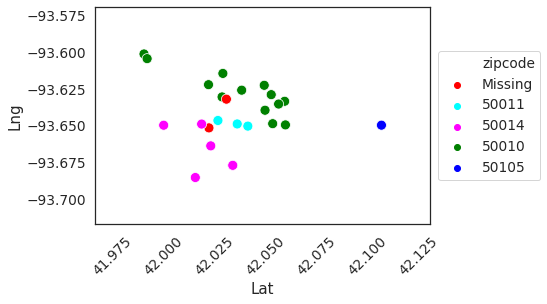

In [47]:
sns.scatterplot(x='Lat',y='Lng',
                data=geo_df,
                hue='zipcode',
                palette=['red','cyan','magenta','green','blue'],
                alpha=1,s=100)
plt.legend(loc='center right',bbox_to_anchor = (1.35,0.5))
_=plt.xticks(rotation=45)

It will be reasonable to impute missing zipcodes with the closest neighbors, but there is another library that can provide zipcode info based on geo coordinates. 

It is the **uszipcode** library https://pypi.org/project/uszipcode/

This library can be used to extract demographic information of different locations in US.

### **1.3.2. uszipcode**
In this section, we will impute the missing zipcode, as well as augment our dataset with more features like popution density, total population, median household income, total number of housing units, etc.

In [48]:
from uszipcode import SearchEngine

In [49]:
def getMoreFeat(a,b):
    '''
    Can take zipcode or [lat,lng] as inputs (a) and return requested information about location, 
    The information requested should be specifed as the second argument (b).

    Acceptable requests are:'lat', 'lng', 
                            'population', 'zipcode', 
                            'population_density','housing_units',
                            'occupied_housing_units', 'median_home_value'
                            'median_household_income'
    
    '''
    def getZipCode(a):
        geo_info = search.by_coordinates(a[0],a[1],radius=5)
        i = 0
        while True:
            if i == len(geo_info):
                idx = None
                break
            elif (geo_info[i].post_office_city == 'Ames, IA') and (geo_info[i].major_city == 'Ames') and (geo_info[i].common_city_list[0] == 'Ames'):
                idx = i
                break
            i += 1
            
        if idx == None:
            print("Coordinates don't belong to Ames, IA. NaN returned")
            return np.nan
        else:
            return geo_info[idx].to_dict()[b]
    
    def getRequest(zipcode,b):
        geo_info = search.by_zipcode(zipcode)
        return geo_info.to_dict()[b]
        
        
    search = SearchEngine(simple_zipcode=True)
    
    if b == 'zipcode': 
        return getZipCode(a)
    elif b in ['lat', 'lng', 'population', 'zipcode', 
                  'population_density','housing_units',
                  'occupied_housing_units', 'median_home_value',
                  'median_household_income']:
        return getRequest(a,b)
        

In [50]:
geo_df.loc[geo_df.zipcode=='Missing','zipcode'] = geo_df.loc[geo_df.zipcode=='Missing',['Lat','Lng']].apply(getMoreFeat,axis=1,b='zipcode')

In [51]:
geo_df['median_household_income'] = geo_df['zipcode'].apply(getMoreFeat,b='median_household_income')
geo_df['median_home_value'] = geo_df['zipcode'].apply(getMoreFeat,b='median_home_value')
geo_df

,Neighborhood,Lat,Lng,zipcode,median_household_income,median_home_value
0,CollgCr,42.022197,-93.651510,50010,48189.0,165300.0
1,Veenker,42.041304,-93.650302,50011,NaN,NaN
2,Crawfor,42.018614,-93.648898,50014,37661.0,212500.0
3,NoRidge,42.053510,-93.648636,50010,48189.0,165300.0
4,Mitchel,41.990308,-93.601053,50010,48189.0,165300.0
5,Somerst,42.049749,-93.639467,50010,48189.0,165300.0
6,NWAmes,42.038277,-93.625770,50010,48189.0,165300.0
7,OldTown,42.029046,-93.614340,50010,48189.0,165300.0
8,BrkSide,42.028653,-93.630386,50010,48189.0,165300.0
9,Sawyer,42.033903,-93.677066,50014,37661.0,212500.0


There are missing values in median_household_income and median_home_value column. 

Lets impute missing values using K-nearest neighbor imputer.

In [52]:
from missingpy import KNNImputer

In [53]:
geo_df['zipcode'] = geo_df.zipcode.astype(int)

In [54]:
imputer = KNNImputer(n_neighbors=2,weights='distance')

In [55]:
geo_df.set_index('Neighborhood',inplace=True)
geo_df = pd.DataFrame(imputer.fit_transform(geo_df),columns=geo_df.columns,index=geo_df.index)
geo_df.reset_index(inplace=True)

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)


In [56]:
geo_df

,Neighborhood,Lat,Lng,zipcode,median_household_income,median_home_value
0,CollgCr,42.022197,-93.651510,50010.0,48189.0,165300.0
1,Veenker,42.041304,-93.650302,50011.0,48189.0,165300.0
2,Crawfor,42.018614,-93.648898,50014.0,37661.0,212500.0
3,NoRidge,42.053510,-93.648636,50010.0,48189.0,165300.0
4,Mitchel,41.990308,-93.601053,50010.0,48189.0,165300.0
5,Somerst,42.049749,-93.639467,50010.0,48189.0,165300.0
6,NWAmes,42.038277,-93.625770,50010.0,48189.0,165300.0
7,OldTown,42.029046,-93.614340,50010.0,48189.0,165300.0
8,BrkSide,42.028653,-93.630386,50010.0,48189.0,165300.0
9,Sawyer,42.033903,-93.677066,50014.0,37661.0,212500.0


In [57]:
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
Neighborhood               25 non-null object
Lat                        25 non-null float64
Lng                        25 non-null float64
zipcode                    25 non-null float64
median_household_income    25 non-null float64
median_home_value          25 non-null float64
dtypes: float64(5), object(1)
memory usage: 1.2+ KB


Now that geo_df, which includes geographical and demographical information, is ready. Lets merge it with the main dataframe 

Let's merge the addtional features to the main dataset.

In [58]:
housing.reset_index(inplace=True)
housing = housing.merge(geo_df,how='left')
housing.set_index('Id',inplace=True)

In [59]:
## Add newly added numerical features to FEATURES
for feature in housing.columns:
    if (housing[feature].dtypes!= 'object') and (feature not in FEATURES['num']) and ('SalePrice' not in feature):
        FEATURES['num'].append(feature)

In [60]:
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleType,SaleCondition,SalePrice,log1p(SalePrice),log1p(GrLivArea),Lat,Lng,zipcode,median_household_income,median_home_value
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Missing,Reg,Lvl,AllPub,Inside,...,WD,Normal,208500,12.247699,7.444833,42.022197,-93.651510,50010.0,48189.0,165300.0
2,20,RL,80.0,9600,Pave,Missing,Reg,Lvl,AllPub,FR2,...,WD,Normal,181500,12.109016,7.141245,42.041304,-93.650302,50011.0,48189.0,165300.0
3,60,RL,68.0,11250,Pave,Missing,IR1,Lvl,AllPub,Inside,...,WD,Normal,223500,12.317171,7.488294,42.022197,-93.651510,50010.0,48189.0,165300.0
4,70,RL,60.0,9550,Pave,Missing,IR1,Lvl,AllPub,Corner,...,WD,Abnorml,140000,11.849405,7.448916,42.018614,-93.648898,50014.0,37661.0,212500.0
5,60,RL,84.0,14260,Pave,Missing,IR1,Lvl,AllPub,FR2,...,WD,Normal,250000,12.429220,7.695758,42.053510,-93.648636,50010.0,48189.0,165300.0


Correlations of the newly added geographic and demograpic features with the target variable. 

Text(0.5, 1, 'Correlation Matrix')

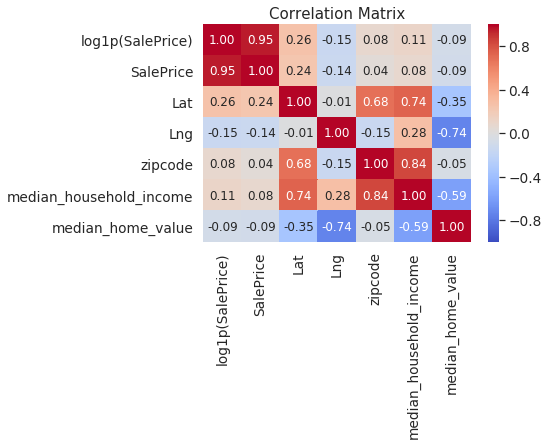

In [61]:
plt.figure(figsize=(6,4))
sns.heatmap(housing[['log1p(SalePrice)','SalePrice','Lat','Lng','zipcode','median_household_income','median_home_value']].corr(),
           vmin=-1,vmax=1,cmap='coolwarm',annot=True,annot_kws=dict(size=12),fmt='.2f')
plt.title('Correlation Matrix')

Correlations are high, but lets keep these features for now. We will come back to this later.

In [62]:
print('Dimensions of the dataset',housing[FEATURES['num']+FEATURES['cat']].shape)

Dimensions of the dataset (1443, 85)


**At this point, data is free of outliers and missing values.**

## **2. Feature Engneering**


### **Ordinal ecoding**: Description of following categorical feature indicate they have ordinal categories
- LandSlope
- ExterQual
- ExterCond
- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- HeatingQC
- KitchenQual
- FireplaceQu
- GarageFinish
- GarageQual
- GarageCond
- PavedDrive
- PoolQC

In [63]:
ordinal_map = {'LandSlope':{'Gtl':0,'Mod':1,'Sev':2},
               'ExterQual':{'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0},
               'ExterCond':{'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0},
               'BsmtQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'Missing':0}, # Houses that don't have a basement are assigned Typical/Average rating
               'BsmtCond':{'Gd':4, 'TA':3, 'Fa':2, 'Po':1,'Missing':0},
               'BsmtExposure':{'Gd':4,'Av':3,'Mn':2,'No':1,'Missing':0},
               'BsmtFinType1': {'Missing': 0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
               'BsmtFinType2': {'Missing': 0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
               'HeatingQC':{'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4},
               'KitchenQual':{'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0},
               'FireplaceQu':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'Missing':0},
               'GarageFinish':{'Fin':3, 'RFn':2, 'Unf':1, 'Missing':0},
               'GarageQual':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Missing':0},
               'GarageCond':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Missing':0},
               'PavedDrive':{'Y':2, 'P':1, 'N':0},
               'PoolQC':{'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Missing':0}}

In [64]:
housing_cat_encoded = housing[FEATURES['cat']].replace(ordinal_map)
# convert the ordinal features to numeric data type (float)
for col in housing_cat_encoded[list(ordinal_map.keys())]:
    housing_cat_encoded[col] = housing_cat_encoded[col].astype(float)
housing_cat_encoded[ordinal_map.keys()].head()

,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC
Id,,,,,,,,,,,,,,,,
1,0.0,3.0,2.0,4.0,3.0,1.0,6.0,1.0,4.0,3.0,0.0,2.0,3.0,3.0,2.0,0.0
2,0.0,2.0,2.0,4.0,3.0,4.0,5.0,1.0,4.0,2.0,3.0,2.0,3.0,3.0,2.0,0.0
3,0.0,3.0,2.0,4.0,3.0,2.0,6.0,1.0,4.0,3.0,3.0,2.0,3.0,3.0,2.0,0.0
4,0.0,2.0,2.0,3.0,4.0,1.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,2.0,0.0
5,0.0,3.0,2.0,4.0,3.0,3.0,6.0,1.0,4.0,3.0,3.0,2.0,3.0,3.0,2.0,0.0


### **One hot ecoding**: one hot encode following features

- MSSubClass
- MSZoning
- Street
- Alley
- LotShape
- LandContour
- Utilities
- LotConfig
- Neighborhood
- Condition1
- Condition2
- BldgType
- HouseStyle
- RoofStyle
- RoofMatl
- Exterior1st
- Exterior2nd
- MasVnrType
- Foundation
- Heating
- CentralAir
- Electrical
- Functional
- GarageType
- Fence
- MiscFeature
- SaleType
- SaleCondition

In [65]:
housing_cat_encoded = pd.get_dummies(housing_cat_encoded,drop_first=True)

In [66]:
FEATURES['encoded_cat'] = []
for col in housing_cat_encoded.columns:
    FEATURES['encoded_cat'].append(col)

### Prepare the training set

In [67]:
train = pd.concat([housing_cat_encoded,housing[FEATURES['num']]],axis=1)
y = housing['log1p(SalePrice)']

### **Feature engineering**
- Check pairwise feature correlations
- Create interaction of feature pairs with high correlations (>0.4)

In [68]:
corr_df = train.corr()

In [69]:
''' Create a dictionary with feature pairs as keys and their correlations as values'''
corr_dict = {}
for key, val in corr_df.unstack().to_dict().items():
    if (key == key[::-1]) or (key in corr_dict) or (key[::-1] in corr_dict):
        pass
    else:
        corr_dict[key] = val

In [70]:
'''Find feature pairs with corr > 0.4'''
high_corr_dict = {}
targetCorr = 0.4
for key, val in corr_dict.items():
    if val > targetCorr:
        high_corr_dict[key] = val
        
print('Total pairs with corr greater than %.2f: %i' %(targetCorr,len(high_corr_dict)))

'''Sort corr dict in descending order'''
from collections import OrderedDict
high_corr_dict = OrderedDict(sorted(high_corr_dict.items(), key=lambda x: x[1],reverse=True))
#print(high_corr_dict)

Total pairs with corr greater than 0.40: 213


In [71]:
interactions = []
for feat1, feat2 in high_corr_dict:
    train['X'.join([feat1,feat2])] = train[feat1] * train[feat2]
    interactions.append('X'.join([feat1,feat2]))

## **Correlation with the target variable**

High correlations with newly engineered feature is a good indication.

In [72]:
train.corrwith(y,method='spearman').sort_values(ascending=False)

OverallQualXlog1p(GrLivArea)               0.859512
OverallQualXGrLivArea                      0.853621
KitchenQualXGrLivArea                      0.835965
ExterQualXGrLivArea                        0.835361
OverallQualXGarageCars                     0.833240
OverallQualXYearBuilt                      0.828259
OverallQualXYearRemodAdd                   0.825150
ExterQualXlog1p(GrLivArea)                 0.822903
ExterQualXOverallQual                      0.818428
BsmtQualXOverallQual                       0.817425
OverallQualXGarageYrBlt                    0.815093
OverallQual                                0.813875
KitchenQualXOverallQual                    0.813739
GrLivAreaXGarageCars                       0.810813
OverallQualXFullBath                       0.810122
KitchenQualXlog1p(GrLivArea)               0.807933
OverallQualXGarageArea                     0.802930
GarageCarsXlog1p(GrLivArea)                0.801347
GrLivAreaXGarageArea                       0.797965
OverallQualX

In [73]:
##with open('../data/01-House-Price/FE_data.pkl','wb') as file:
#    pickle.dump((FEATURES,ordinal_map,interactions,train,y),file)

## **Building ML model**

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1010, 442)
X_test : (433, 442)
y_train : (1010,)
y_test : (433,)


# **Feature Standardizing**
- Perform standardization on all features except those one hot encoded.

In [75]:
feat_to_norm = FEATURES['cont'] + list(ordinal_map.keys()) + [inter for inter in interactions if len(inter.split('_')) < 3]

In [76]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train[feat_to_norm])

X_num_train_norm = pd.DataFrame(ss.transform(X_train[feat_to_norm]),columns=feat_to_norm,index=X_train.index)
X_cat_train = X_train[[col for col in X_train.columns if col not in feat_to_norm]]
X_train_preproc = pd.concat([X_num_train_norm,X_cat_train],axis=1)

X_num_test_norm = pd.DataFrame(ss.transform(X_test[feat_to_norm]),columns=feat_to_norm,index=X_test.index)
X_cat_test = X_test[[col for col in X_test.columns if col not in feat_to_norm]]
X_test_preproc = pd.concat([X_num_test_norm,X_cat_test],axis=1)

In [77]:
from collections import namedtuple

models = namedtuple('models',['name','params',
                              'cv5_mean_accuracy_train','cv5_std_accuracy_train',
                              'cv5_mean_accuracy_test','cv5_std_accuracy_test'])
model_list = []

## **Linear Regression**

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score

In [79]:
def cv_rmse(mod,X,y,cv=5):
    scores = cross_val_score(mod,X,y,scoring="neg_mean_squared_error",cv=cv)
    return np.sqrt(-scores)

In [80]:
lr = LinearRegression()
lr.fit(X_train_preproc,y_train)


y_train_pred = lr.predict(X_train_preproc)
y_test_pred = lr.predict(X_test_preproc)

print('Train R-sq:',r2_score(y_train,y_train_pred))
print('Test R-sq:',r2_score(y_test,y_test_pred))

Train R-sq: 0.9648997602147961
Test R-sq: 0.8187786701044254


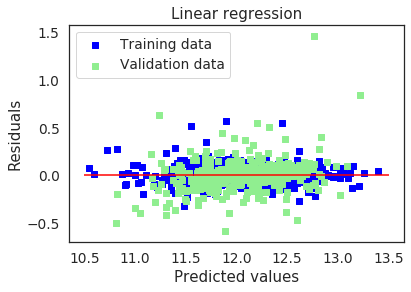

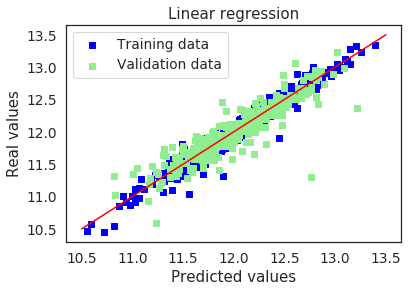

In [81]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

In [82]:
cv5_accuracy_train =  cv_rmse(lr, X_train_preproc, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(lr, X_test_preproc, y_test, cv=5)

print('CV5 train accuracies:',cv5_accuracy_train)
print('-'*75)
print('CV5 test accuracies:', cv5_accuracy_test)

model_list.append(models(name='LR',params=lr.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train accuracies: [0.21137479 0.55761729 0.1560347  0.20541472 0.15819899]
---------------------------------------------------------------------------
CV5 test accuracies: [ 9.06037358 13.60317725 16.92625665  2.86871186  7.45164885]


## **Linear Regression with Ridge regularization (L2 penatly)**

In [83]:
from sklearn.linear_model import RidgeCV, Ridge

ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train_preproc, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 30.0


In [84]:
ridge = Ridge(alpha=1)
ridge.fit(X_train_preproc, y_train)
y_pred = ridge.predict(X_test_preproc)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.8995453551106012
MSE: 0.013993106963117858
RMSE: 0.11829246367845188
--------------------------------------------------
R-sq orig price: 0.9039647166208027
MSE orig price: 478126092.0751885
RMSE orig price: 21866.09457756891


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79889e-21): result may not be accurate.
  overwrite_a=True).T


In [85]:
ridge = Ridge(alpha=30)
ridge.fit(X_train_preproc, y_train)
y_pred = ridge.predict(X_test_preproc)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9139519402751554
MSE: 0.011986301927842193
RMSE: 0.10948197078899427
--------------------------------------------------
R-sq orig price: 0.9144926527000864
MSE orig price: 425711179.99199426
RMSE orig price: 20632.769566686733


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.19713e-20): result may not be accurate.
  overwrite_a=True).T


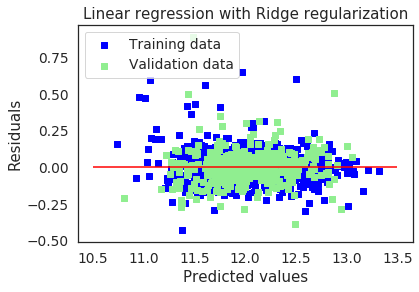

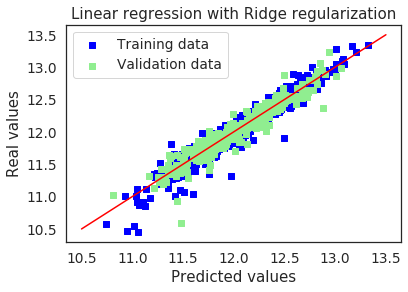

Ridge picked 437 features and eliminated the other 5 features


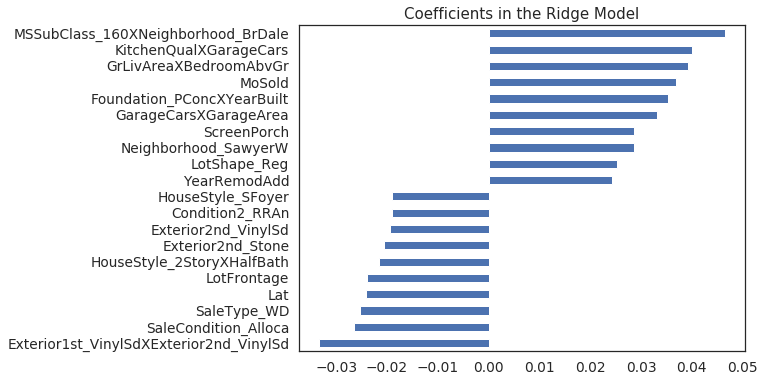

In [86]:
y_train_rdg = ridge.predict(X_train_preproc)
y_test_rdg = ridge.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Ridge Model");

In [87]:
cv5_accuracy_train =  cv_rmse(ridge, X_train_preproc, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(ridge, X_test_preproc, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='ridge',params=ridge.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.06637e-20): result may not be accurate.
  overwrite_a=True).T
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.78039e-20): result may not be accurate.
  overwrite_a=True).T
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.72997e-20): result may not be accurate.
  overwrite_a=True).T
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.22096e-20): result may not be accurate.
  overwrite_a=True).T
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.09144e-20): result may not be accurate.
  overwrite_a=True).T
/home/climbach/

CV5 train R-sq: [0.10384074 0.117603   0.10407569 0.14634584 0.10032554]
---------------------------------------------------------------------------
CV5 test R-sq: [0.32704771 0.21836311 0.269817   0.41498083 0.42847953]


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


## **Linear Regression with Lasso regularization (L1 penalty)**

In [88]:
from sklearn.linear_model import LassoCV, Lasso

In [89]:
lasso = Lasso(alpha=1)
lasso.fit(X_train_preproc, y_train)
y_pred = lasso.predict(X_test_preproc)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

R-sq: 0.8136527296255429
MSE: 0.02595775724961031
RMSE: 0.16111411250914773
--------------------------------------------------
R-sq orig price: 0.8092273561823071
MSE orig price: 949790279.7167525
RMSE orig price: 30818.66771482428


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.655079528728756, tolerance: 0.016279907156276183
  positive)


In [90]:
lasso = Lasso(alpha=0.0003)
lasso.fit(X_train_preproc, y_train)
y_pred = lasso.predict(X_test_preproc)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))


y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

R-sq: 0.9135506009431602
MSE: 0.012042207597582982
RMSE: 0.10973699284007642
--------------------------------------------------
R-sq orig price: 0.916490626402915
MSE orig price: 415763967.62390554
RMSE orig price: 20390.29101371301


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.305870043214787, tolerance: 0.016279907156276183
  positive)


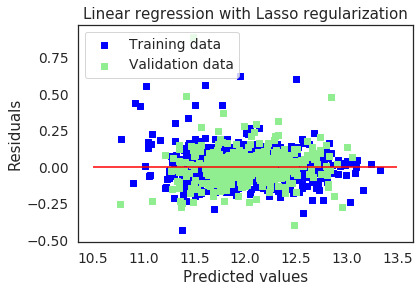

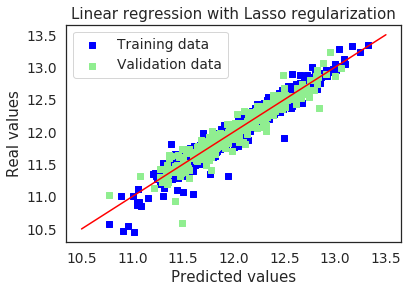

Lasso picked 183 features and eliminated the other 259 features


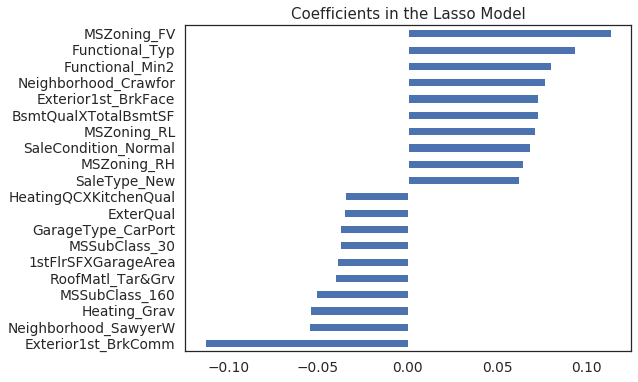

In [91]:
y_train_las = lasso.predict(X_train_preproc)
y_test_las = lasso.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train_preproc.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Lasso Model");

In [92]:
cv5_accuracy_train =  cv_rmse(lasso, X_train_preproc, y_train, cv=5)
cv5_accuracy_test = cv_rmse(lasso, X_test_preproc, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='lasso',params=lasso.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.262953760822813, tolerance: 0.013795237924590231
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9673531117067458, tolerance: 0.012943336987437614
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.245094963276787, tolerance: 0.013157892506500804
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want t

CV5 train R-sq: [0.10644001 0.11894363 0.10556564 0.14260364 0.10213667]
---------------------------------------------------------------------------
CV5 test R-sq: [0.13285154 0.11497678 0.13892433 0.11195439 0.11409682]


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0535005591802948, tolerance: 0.004803317500323421
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.039441654802515, tolerance: 0.005124729527928506
  positive)


## **Linear Regression with ElasticNet Regularization (L1 and L2 penalty)**

In [93]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import RandomizedSearchCV

In [94]:
enet = ElasticNet(alpha=1,l1_ratio=0.5)
enet.fit(X_train_preproc,y_train)
y_pred = enet.predict(X_test_preproc)

print('R-sq:', r2_score(y_test,y_pred))
print('MSE:', mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:', r2_score(y_test_exp,y_pred_exp))
print('MSE:', mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:', np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8257551033002903
MSE: 0.024271923712248063
RMSE: 0.15579449191883538
--------------------------------------------------
R-sq: 0.824909696354392
MSE: 871713392.1683897
RMSE: 29524.792838704045


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.941404313035532, tolerance: 0.016279907156276183
  positive)


In [95]:
enet = ElasticNet(l1_ratio=0,alpha=0.03)
enet.fit(X_train_preproc,y_train)
y_pred = enet.predict(X_test_preproc)

print('R-sq:', r2_score(y_test,y_pred))
print('MSE:', mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:', r2_score(y_test_exp,y_pred_exp))
print('MSE:', mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:', np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.9140009418415959
MSE: 0.01197947611942571
RMSE: 0.10945079314205863
--------------------------------------------------
R-sq: 0.9143751129914812
MSE: 426296369.09709793
RMSE: 20646.945757111338


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.397951053118929, tolerance: 0.016279907156276183
  positive)


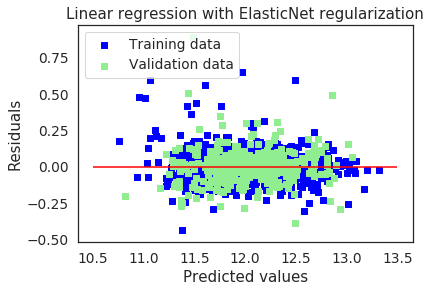

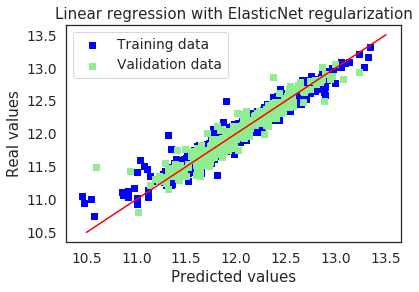

ElasticNet picked 437 features and eliminated the other 5 features


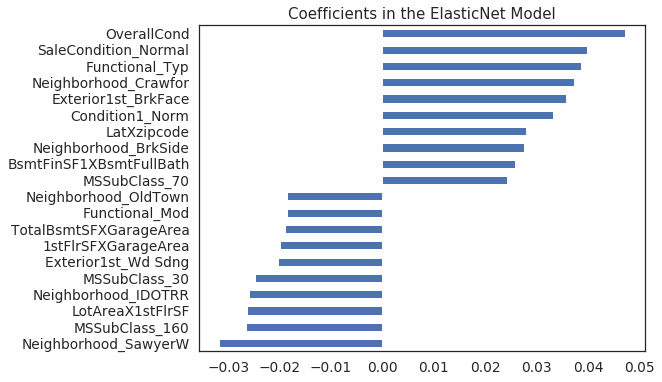

In [96]:
y_train_ela = enet.predict(X_train_preproc)
y_test_ela = enet.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(enet.coef_, index = X_train_preproc.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the ElasticNet Model");

In [97]:
cv5_accuracy_train =  cv_rmse(enet, X_train_preproc, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(enet, X_test_preproc, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='ElasticNet',params=enet.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4109250235203, tolerance: 0.013795237924590231
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.074901565330046, tolerance: 0.012943336987437614
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.360511360654178, tolerance: 0.013157892506500804
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to i

CV5 train R-sq: [0.10358655 0.11762476 0.10529971 0.14575377 0.09973561]
---------------------------------------------------------------------------
CV5 test R-sq: [0.12995715 0.10453687 0.13171092 0.09724794 0.10489   ]


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.184496499550896, tolerance: 0.005124729527928506
  positive)


## **Support Vector Machine Regression**

In [99]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [ ]:
svm = SVR(C=0.1, cache_size=200, coef0=1, degree=3, epsilon=0.1,
          gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
          tol=0.001, verbose=False)
svm.fit(X_train_preproc,y_train)
y_pred = svm.predict(X_test_preproc)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

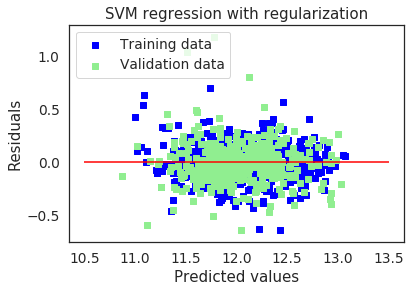

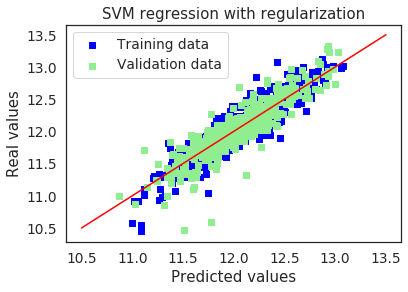

SVR picked up 237 features and eliminated 15 features


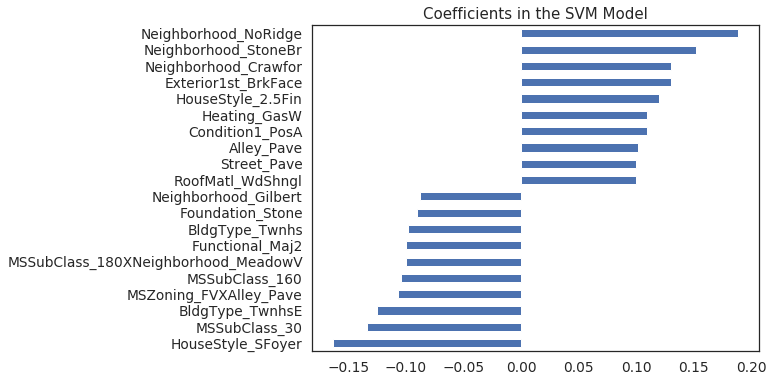

In [99]:
y_train_svm = svm.predict(X_train_preproc)
y_test_svm = svm.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_svm, y_train_svm - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test_svm - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_svm, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(np.squeeze(svm.coef_) , index = X_train_preproc.columns)
print("SVR picked up " + str(sum(coefs != 0)) + " features and eliminated " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the SVM Model");

In [100]:
cv5_accuracy_train =  cv_rmse(svm, X_train_preproc, y_train, cv=5)
cv5_accuracy_test = cv_rmse(svm, X_test_preproc, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='svm',params=svm.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train R-sq: [0.16135073 0.1650075  0.16107999 0.1735172  0.1541674 ]
---------------------------------------------------------------------------
CV5 test R-sq: [0.19511913 0.25445726 0.16615503 0.23688038 0.21915023]


## **Random Forest**

In [98]:
from sklearn.ensemble import RandomForestRegressor

In [99]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8834536010079411
MSE: 0.016234652255828114
RMSE: 0.1274152748136114
--------------------------------------------------
R-sq: 0.8886334028771328
MSE: 554455341.7916255
RMSE: 23546.875414619783


In [100]:
feature_importance = pd.DataFrame(np.round(rf.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace =True)

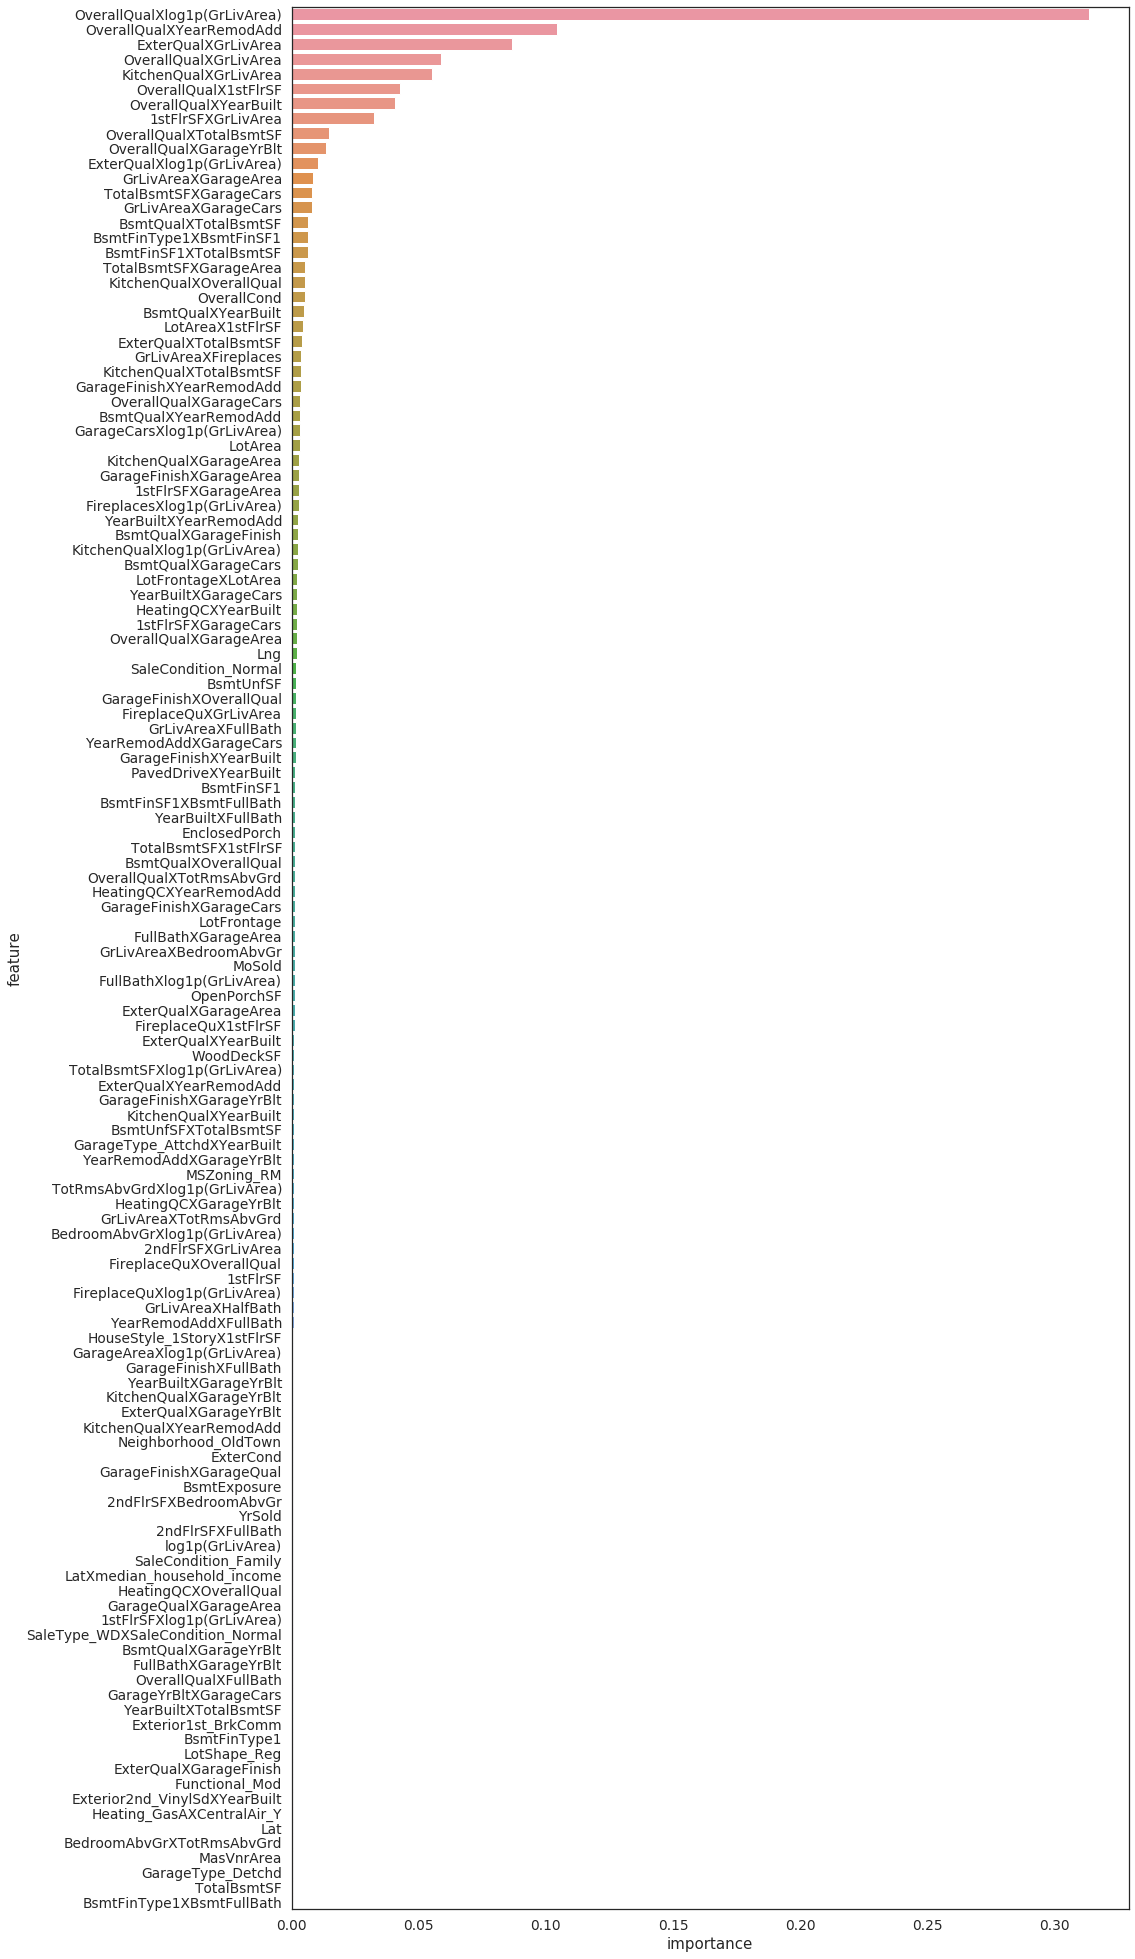

In [101]:
plt.figure(figsize=(15,35))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [102]:
rf = RandomForestRegressor(n_estimators=200,
                           max_depth=75,
                           min_samples_leaf=3,
                           min_samples_split=4)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8813294233632316
MSE: 0.016530545442487735
RMSE: 0.12857116878401523
--------------------------------------------------
R-sq: 0.8885706947919251
MSE: 554767543.4186409
RMSE: 23553.503845896066


In [103]:
feature_importance = pd.DataFrame(np.round(rf.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace =True)

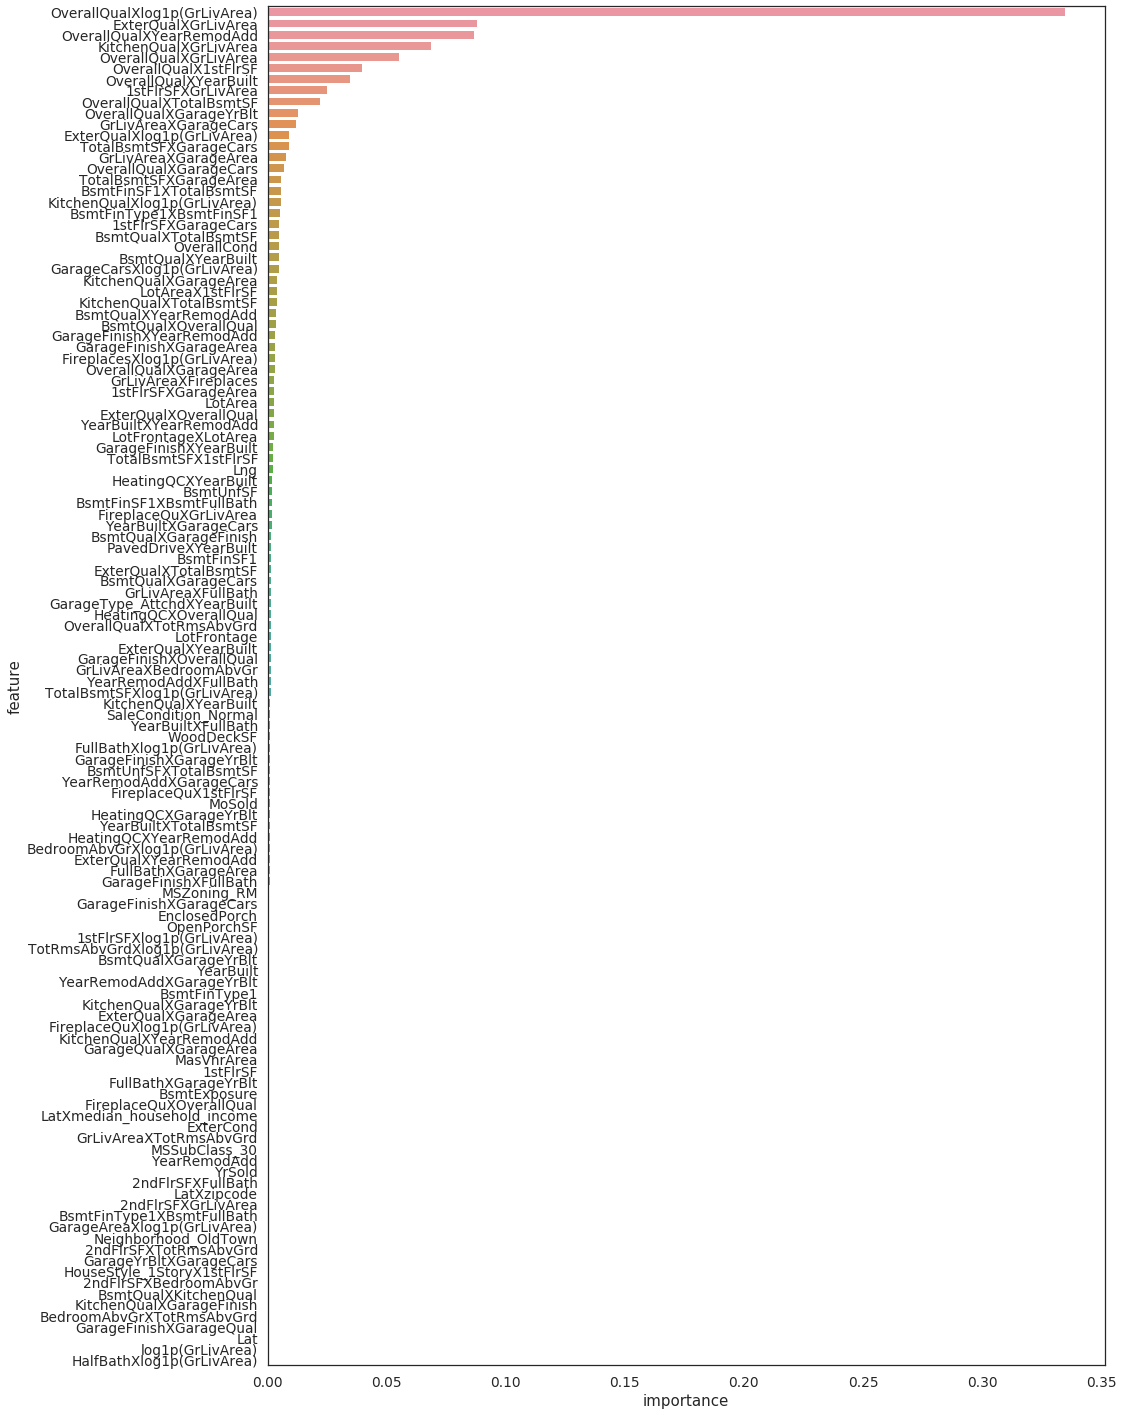

In [104]:
plt.figure(figsize=(15,25))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [105]:
cv5_accuracy_train = cv_rmse(rf, X_train, y_train, cv=5)
cv5_accuracy_test = cv_rmse(rf, X_test, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='rf',params=rf.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train R-sq: [0.11657228 0.14708848 0.12121841 0.17235672 0.14022636]
---------------------------------------------------------------------------
CV5 test R-sq: [0.15060089 0.10647744 0.14777285 0.13700425 0.11968474]


## **Adaptive Boost (AdaBoost)**

In [106]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [107]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=75,
                                                             min_samples_leaf=3,
                                                             min_samples_split= 4),
                       n_estimators=200,learning_rate=0.5,random_state=42)

ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8877194099105631
MSE: 0.01564043463329478
RMSE: 0.12506172329411896
--------------------------------------------------
R-sq: 0.8944227650558686
MSE: 525632132.06362206
RMSE: 22926.668577523906


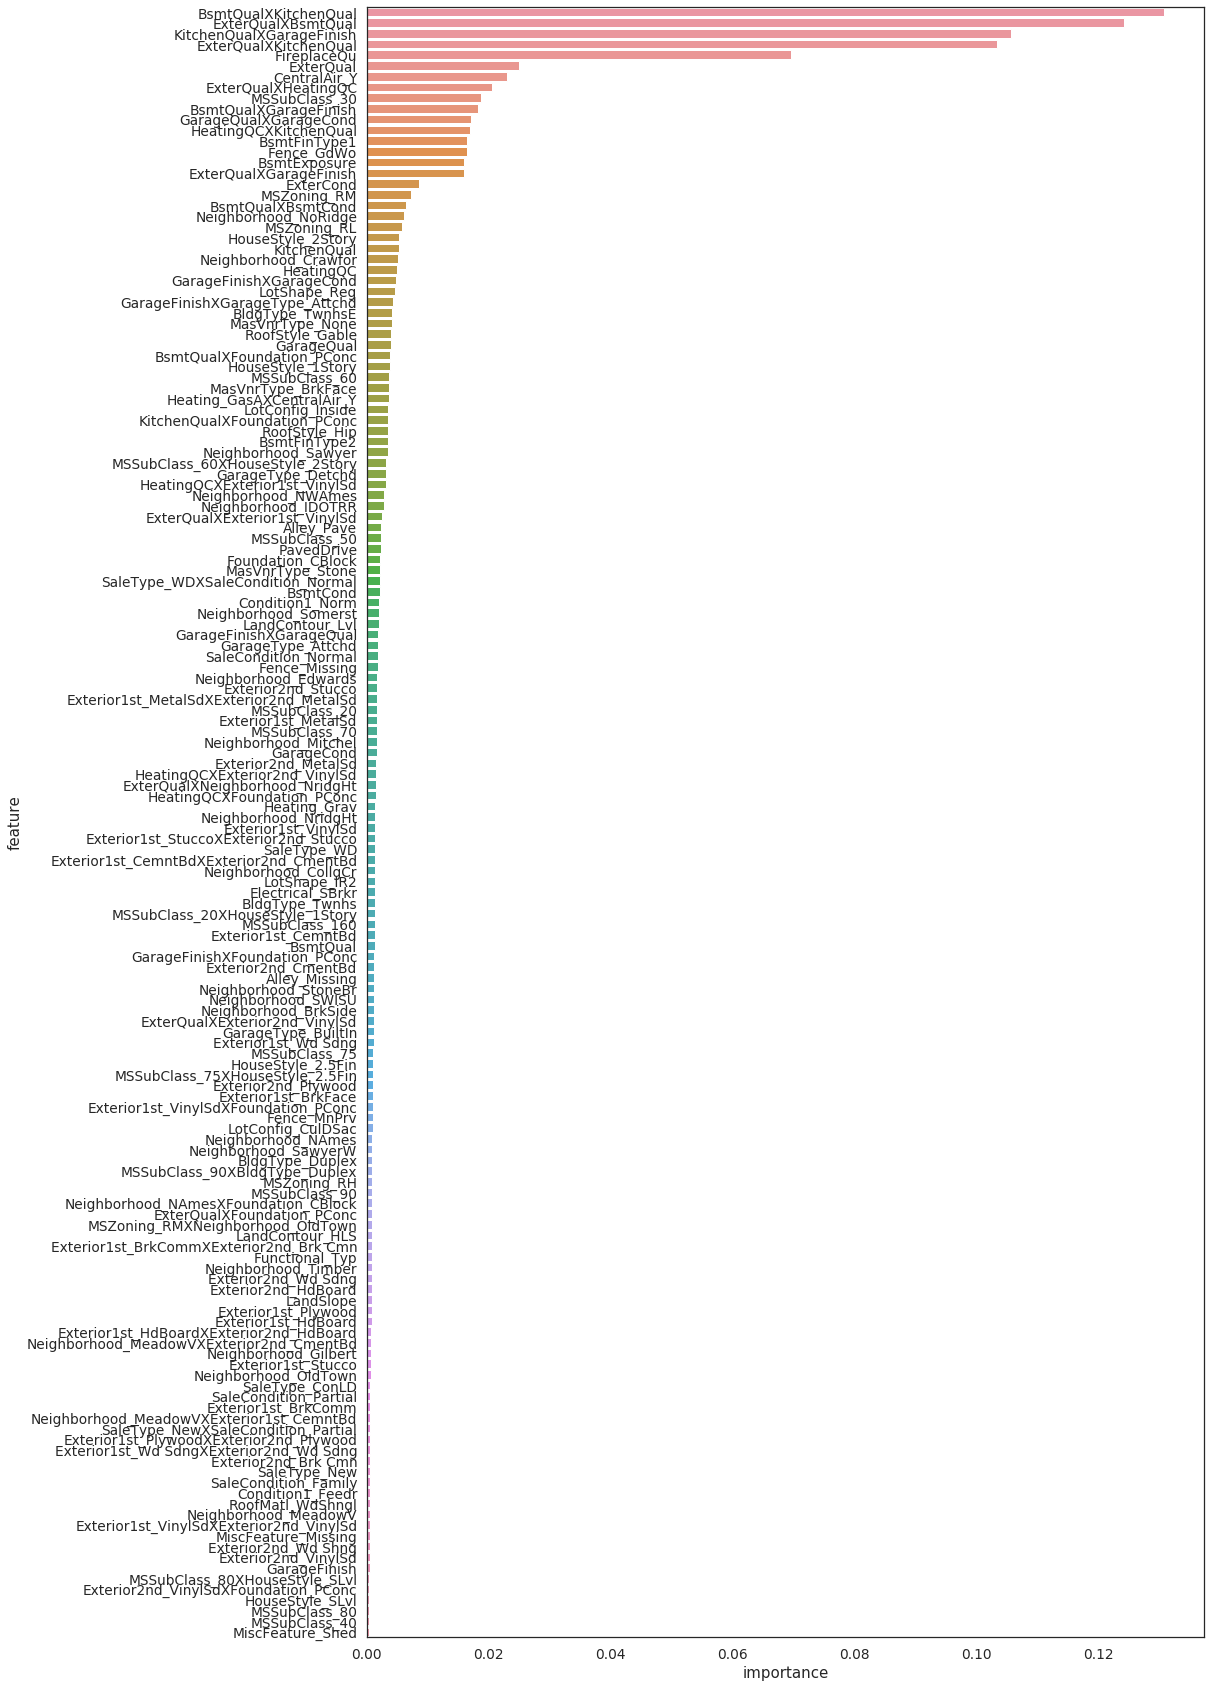

In [112]:
feature_importance = pd.DataFrame(np.round(ada.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace = True)

plt.figure(figsize=(15,30))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [108]:
with open('ada_mod.pkl','rb') as mod_file:
    ada_cv = pickle.load(mod_file)

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator AdaBoostRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [109]:
ada = ada_cv.best_estimator_
ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8869425149328953
MSE: 0.015748654363040303
RMSE: 0.12549364271962266
--------------------------------------------------
R-sq: 0.892963001607166
MSE: 532899783.7903991
RMSE: 23084.622236250674


In [110]:
cv5_accuracy_train =  cv_rmse(ada, X_train, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(ada, X_test, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='ada',params=ada.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train R-sq: [0.11856128 0.14398304 0.12358801 0.17163058 0.14655821]
---------------------------------------------------------------------------
CV5 test R-sq: [0.15262647 0.10675667 0.15448519 0.12418955 0.11492108]


## **Gradient Boost**

In [111]:
from sklearn.ensemble import GradientBoostingRegressor

In [112]:
gbrt = GradientBoostingRegressor()
gbrt.fit(X_train,y_train)
y_pred = gbrt.predict(X_test)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.8959069967953468
MSE: 0.01449992212464232
RMSE: 0.12041562242766642
--------------------------------------------------
R-sq orig price: 0.8987176938008361
MSE orig price: 504249183.7938244
RMSE orig price: 22455.493399028765


In [113]:
cv5_accuracy_train =  cv_rmse(gbrt, X_train, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(gbrt, X_test, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='gbrt',params=gbrt.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train R-sq: [0.11228744 0.12937206 0.10981669 0.16206653 0.12505168]
---------------------------------------------------------------------------
CV5 test R-sq: [0.13992736 0.10393426 0.14218124 0.11399727 0.12563164]


In [114]:
mod_table = pd.DataFrame()
for model in model_list:
    tmp_df = pd.DataFrame([model.name,
                           model.cv5_mean_accuracy_train,
                           model.cv5_std_accuracy_train,
                           model.cv5_mean_accuracy_test,
                           model.cv5_std_accuracy_test],
                          index=['model',
                                   'train_mean_ac',
                                   'train_std_ac',
                                   'test_mean_ac',
                                   'test_std_ac']).T
    
    mod_table = pd.concat([mod_table,tmp_df],axis=0)
    
mod_table.reset_index(drop=True,inplace=True)

In [115]:
for col in mod_table.columns:
    if col != 'model':
        mod_table[col]= mod_table[col].astype(float)

In [116]:
mod_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 5 columns):
model            7 non-null object
train_mean_ac    7 non-null float64
train_std_ac     7 non-null float64
test_mean_ac     7 non-null float64
test_std_ac      7 non-null float64
dtypes: float64(4), object(1)
memory usage: 360.0+ bytes


Text(0.5, 1.0, 'Train vs. Test RMSE')

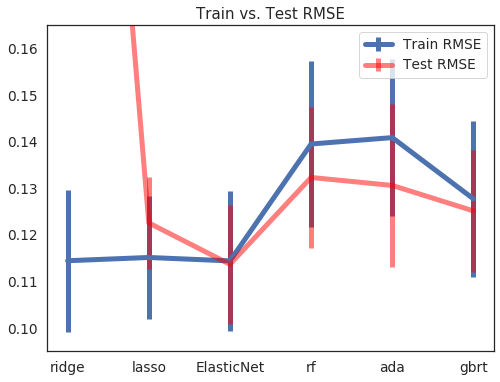

In [124]:
train_errorbar_width_array = (mod_table.loc[1:,'train_std_ac']/np.sqrt(5))*2

plt.figure(figsize =(8,6))
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'train_mean_ac'],
             yerr=train_errorbar_width_array,
             label='Train RMSE',
             linewidth=5)

test_errorbar_width_array = (mod_table.loc[1:,'test_std_ac']/np.sqrt(5))*2
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'test_mean_ac'],
             yerr=test_errorbar_width_array,
             label='Test RMSE',
             linewidth=5,
             color='red',
             alpha =0.5)
plt.legend()
plt.ylim(0.095,0.165)
plt.title('Train vs. Test RMSE')

In [118]:
mod_table.sort_values(by=['test_mean_ac','test_std_ac'],ascending=[True,True])

,model,train_mean_ac,train_std_ac,test_mean_ac,test_std_ac
3,ElasticNet,0.114400,0.016782,0.113669,0.014289
2,lasso,0.115138,0.014867,0.122561,0.011093
6,gbrt,0.127719,0.018699,0.125134,0.014718
5,ada,0.140864,0.018892,0.130596,0.019550
4,rf,0.139492,0.019988,0.132308,0.016867
1,ridge,0.114438,0.017012,0.331738,0.081238
0,LR,0.257728,0.151701,9.982034,4.882347
